In [ ]:
# Step 1-2: Entity Extraction

- Uses spaCy to find people, organizations, money, locations
- Adds custom regex for case numbers
- Creates nodes in the knowledge graph

# Step 3: Relationship Discovery

- Finds entities mentioned in the same sentence
- Infers relationship types (executive, legal action, employment), multiple strategies possible:
    - option1 : keyword rules with Spacy (if sentence contains ceo, executive ... then "EXECUTIVE")
    - option2: Spacy dependency Parsing (rule-based, smarter) to detect grammatical relationship between entities.
    - option3: Pretrained relation extraction models : HF transformers Bert-for-relation-extraction
    - option4: Use directly an LLM with a prompt to extract relationship from text 
- Adds edges between connected entities

Step 4: Visualization

Shows the knowledge graph with colored nodes
Different colors for different entity types
Displays entity names and connections

Step 5-6: GraphRAG Querying

Simple keyword matching to find relevant entities
Expands to include connected entities (multi-hop)
Shows relationships and supporting evidence

Step 7: Traditional vs GraphRAG

Demonstrates how traditional RAG returns isolated chunks
Shows how GraphRAG reveals relationships and patterns

### GraphRAG

In [19]:
import re
import networkx as nx
import matplotlib.pyplot as plt
import spacy
from collections import defaultdict

# Load spaCy (if this fails, run: python -m spacy download en_core_web_sm)
nlp = spacy.load("en_core_web_sm")

In [20]:
# how spacy detect entity via this language model
doc = nlp("I am john and you are marcos. Mark is absent.")
print(doc)
print(doc.ents)

# spacy can tokenize
for token in doc:
    print("tokenize",token.text)

# Spacy can do POS tagging
for token in doc:
    print("POS tagging",token.text, token.pos_)

# Spacy can do NER 
for ent in doc.ents:
    print("NER",ent.text, ent.label_)

# Spacy can do dependency parsing: understand the grammatical relationships between words
for token in doc:
    print("dependency parsing",token.text, token.dep_, token.head.text)

#Lemmatization: get the base form of words
for token in doc:
    print("lemmatization",token.text, token.lemma_)

# Stop word detection
for token in doc:
    if token.is_stop:
        print("stop_word_detection",token.text)

# Text similarity
doc1 = nlp("Apple is a tech company")
doc2 = nlp("Google is a technology firm")
print("text similarity",doc1.similarity(doc2))

# Sentence segmentation
for sent in doc.sents:
    print("sentence segmentation",sent.text)

# Rule-Based matching 
from spacy.matcher import Matcher
matcher = Matcher(nlp.vocab)

I am john and you are marcos. Mark is absent.
(john, marcos, Mark)
tokenize I
tokenize am
tokenize john
tokenize and
tokenize you
tokenize are
tokenize marcos
tokenize .
tokenize Mark
tokenize is
tokenize absent
tokenize .
POS tagging I PRON
POS tagging am AUX
POS tagging john PROPN
POS tagging and CCONJ
POS tagging you PRON
POS tagging are AUX
POS tagging marcos PROPN
POS tagging . PUNCT
POS tagging Mark PROPN
POS tagging is AUX
POS tagging absent ADJ
POS tagging . PUNCT
NER john PERSON
NER marcos PERSON
NER Mark PERSON
dependency parsing I nsubj am
dependency parsing am ROOT am
dependency parsing john attr am
dependency parsing and cc am
dependency parsing you nsubj are
dependency parsing are conj am
dependency parsing marcos attr are
dependency parsing . punct are
dependency parsing Mark nsubj is
dependency parsing is ROOT is
dependency parsing absent acomp is
dependency parsing . punct is
lemmatization I I
lemmatization am be
lemmatization john john
lemmatization and and
lemmatizat

/var/folders/dr/83m5p3m94s7gmtrc3_97lxvc0000gn/T/ipykernel_36083/533509402.py:34: UserWarning: [W007] The model you're using has no word vectors loaded, so the result of the Doc.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  print("text similarity",doc1.similarity(doc2))


In [21]:
for sent in doc.sents:
    print("sentence segmentation",sent.text)

sentence segmentation I am john and you are marcos.
sentence segmentation Mark is absent.


In [22]:
for i in doc: 
    print(i.pos_)

PRON
AUX
PROPN
CCONJ
PRON
AUX
PROPN
PUNCT
PROPN
AUX
ADJ
PUNCT


In [23]:
# Sample legal documents
documents = {
    "doc1": """
    In SEC v. PharmaCorp Inc., Case No. 2023-156, the Securities and Exchange Commission 
    filed charges against PharmaCorp Inc. and its CEO John Smith for securities fraud. 
    The investigation revealed that Smith, along with CFO Sarah Johnson, manipulated drug 
    trial results. PharmaCorp had previously faced FDA warnings. The fraud cost investors 
    $50 million. Similar patterns were observed in SEC Case No. 2022-089 involving BioTech Inc.
    """,
    
    "doc2": """
    United States District Court ruled in favor of the SEC in Case No. 2023-156. 
    Judge Robert Wilson found that PharmaCorp's executives violated securities law. 
    John Smith had previously worked at BioMed Industries, which faced similar SEC violations. 
    Sarah Johnson joined PharmaCorp from the same company. The court ordered $75 million in penalties.
    """,
    
    "doc3": """
    BioTech Inc. was investigated in Case No. 2022-089 for similar fraud patterns. 
    CEO Michael Brown used identical methodologies to deceive investors. 
    The timeline shows FDA warnings preceded SEC investigations by 3 months in both cases.
    Law firm Wilson & Associates represented both PharmaCorp and BioTech Inc.
    """
}

print("📄 Sample Documents Loaded")
print(f"Total documents: {len(documents)}")

# =============================================================================
# STEP 1: Extract Entities from Documents
# =============================================================================

# Create empty graph and entity storage
graph = nx.Graph()
all_entities = []

def extract_entities(text, doc_id):
    """Extract entities using spaCy"""
    doc = nlp(text)
    entities = []
    
    for ent in doc.ents:
        if ent.label_ in ['PERSON', 'ORG', 'MONEY', 'GPE']:  # Focus on key types
            entities.append({
                'text': ent.text,
                'label': ent.label_,
                'doc_id': doc_id,
                'sentence': ent.sent.text
            })
    
    # Also extract case numbers with regex
    case_pattern = r'Case No\. (\d{4}-\d{3})'
    for match in re.finditer(case_pattern, text):
        entities.append({
            'text': match.group(1),
            'label': 'CASE_NUMBER',
            'doc_id': doc_id,
            'sentence': text[max(0, match.start()-50):match.end()+50]
        })
    
    return entities

# Extract entities from all documents
print("\n🔍 Extracting Entities...")
for doc_id, text in documents.items():
    entities = extract_entities(text, doc_id)
    all_entities.extend(entities)
    print(f"{doc_id}: Found {len(entities)} entities")

# Show some entities
print("\n📋 Sample Entities:")
for i, entity in enumerate(all_entities[:10]):
    print(f"{i+1}. {entity['text']} ({entity['label']}) from {entity['doc_id']}")


📄 Sample Documents Loaded
Total documents: 3

🔍 Extracting Entities...
doc1: Found 16 entities
doc2: Found 13 entities
doc3: Found 8 entities

📋 Sample Entities:
1. SEC (ORG) from doc1
2. PharmaCorp Inc. (ORG) from doc1
3. Case No (ORG) from doc1
4. the Securities and Exchange Commission (ORG) from doc1
5. PharmaCorp Inc. (ORG) from doc1
6. John Smith (PERSON) from doc1
7. Smith (PERSON) from doc1
8. CFO (ORG) from doc1
9. Sarah Johnson (PERSON) from doc1
10. PharmaCorp (ORG) from doc1


In [24]:
# =============================================================================
# STEP 2: Add Entities to Graph
# =============================================================================

print("\n🕸️ Building Knowledge Graph...")

# Add entities as nodes
entity_counts = defaultdict(int)
for entity in all_entities:
    node_id = f"{entity['text']}_{entity['label']}"
    
    if not graph.has_node(node_id):
        graph.add_node(node_id, 
                      name=entity['text'], 
                      type=entity['label'],
                      docs=[entity['doc_id']],
                      count=1)
    else:
        # Update existing node
        graph.nodes[node_id]['count'] += 1
        if entity['doc_id'] not in graph.nodes[node_id]['docs']:
            graph.nodes[node_id]['docs'].append(entity['doc_id'])
    
    entity_counts[entity['label']] += 1

print(f"Added {len(graph.nodes)} unique entities to graph")
print("Entity types:", dict(entity_counts))


🕸️ Building Knowledge Graph...
Added 21 unique entities to graph
Entity types: {'ORG': 23, 'PERSON': 7, 'MONEY': 2, 'CASE_NUMBER': 4, 'GPE': 1}


In [25]:
graph

In [26]:
# =============================================================================
# STEP 3: Create Relationships
# =============================================================================

def find_relationships(text, doc_id):
    """Find relationships between entities in sentences"""
    doc = nlp(text)
    relationships = []
    
    for sent in doc.sents:
        # Get entities in this sentence
        sent_entities = []
        for ent in sent.ents:
            if ent.label_ in ['PERSON', 'ORG', 'MONEY', 'GPE']:
                sent_entities.append((ent.text, ent.label_))
        
        # Also check for legal case numbers
        case_matches = re.findall(r'Case No\. (\d{4}-\d{3})', sent.text)
        for case in case_matches:
            sent_entities.append((case, 'CASE_NUMBER'))
        
        print("sent_entities", sent_entities)
        # Create relationships between entities in same sentence
        for i, (ent1, type1) in enumerate(sent_entities):
            for ent2, type2 in sent_entities[i+1:]:
                # Determine relationship type based on sentence content
                rel_type = "MENTIONED_WITH"
                sent_lower = sent.text.lower()
                
                if any(word in sent_lower for word in ['ceo', 'president', 'officer']):
                    rel_type = "EXECUTIVE_OF"
                elif any(word in sent_lower for word in ['sued', 'charges', 'violation']):
                    rel_type = "LEGAL_ACTION"
                elif any(word in sent_lower for word in ['worked', 'joined', 'from']):
                    rel_type = "EMPLOYMENT"
                
                relationships.append({
                    'source': f"{ent1}_{type1}",
                    'target': f"{ent2}_{type2}",
                    'type': rel_type,
                    'doc_id': doc_id,
                    'context': sent.text
                })
    
    return relationships

# Find relationships in all documents
print("\n🔗 Finding Relationships...")
all_relationships = []
for doc_id, text in documents.items():
    relationships = find_relationships(text, doc_id)
    all_relationships.extend(relationships)
    print(f"{doc_id}: Found {len(relationships)} relationships")

# Add relationships to graph
for rel in all_relationships:
    if (graph.has_node(rel['source']) and graph.has_node(rel['target'])):
        if not graph.has_edge(rel['source'], rel['target']):
            graph.add_edge(rel['source'], rel['target'], 
                          relation_type=rel['type'],
                          docs=[rel['doc_id']],
                          contexts=[rel['context']])
        else:
            # Update existing edge
            if rel['doc_id'] not in graph.edges[rel['source'], rel['target']]['docs']:
                graph.edges[rel['source'], rel['target']]['docs'].append(rel['doc_id'])
                graph.edges[rel['source'], rel['target']]['contexts'].append(rel['context'])

print(f"Added {len(graph.edges)} relationships to graph")


🔗 Finding Relationships...
sent_entities [('SEC', 'ORG'), ('PharmaCorp Inc.', 'ORG'), ('Case No', 'ORG'), ('the Securities and Exchange Commission', 'ORG'), ('PharmaCorp Inc.', 'ORG'), ('John Smith', 'PERSON'), ('2023-156', 'CASE_NUMBER')]
sent_entities [('Smith', 'PERSON'), ('CFO', 'ORG'), ('Sarah Johnson', 'PERSON')]
sent_entities [('PharmaCorp', 'ORG'), ('FDA', 'ORG')]
sent_entities [('$50 million', 'MONEY')]
sent_entities [('SEC', 'ORG'), ('BioTech Inc.', 'ORG'), ('2022-089', 'CASE_NUMBER')]
doc1: Found 28 relationships
sent_entities [('United States', 'GPE'), ('District Court', 'ORG'), ('SEC', 'ORG'), ('Case No', 'ORG'), ('2023-156', 'CASE_NUMBER')]
sent_entities [('Robert Wilson', 'PERSON'), ('PharmaCorp', 'ORG')]
sent_entities [('John Smith', 'PERSON'), ('BioMed Industries', 'ORG'), ('SEC', 'ORG')]
sent_entities [('Sarah Johnson', 'PERSON'), ('PharmaCorp', 'ORG')]
sent_entities [('$75 million', 'MONEY')]
doc2: Found 15 relationships
sent_entities [('BioTech Inc.', 'ORG'), ('202

In [27]:
graph.nodes

NodeView(('SEC_ORG', 'PharmaCorp Inc._ORG', 'Case No_ORG', 'the Securities and Exchange Commission_ORG', 'John Smith_PERSON', 'Smith_PERSON', 'CFO_ORG', 'Sarah Johnson_PERSON', 'PharmaCorp_ORG', 'FDA_ORG', '$50 million_MONEY', 'BioTech Inc._ORG', '2023-156_CASE_NUMBER', '2022-089_CASE_NUMBER', 'United States_GPE', 'District Court_ORG', 'Robert Wilson_PERSON', 'BioMed Industries_ORG', '$75 million_MONEY', 'Michael Brown_PERSON', 'Wilson & Associates_ORG'))


🎨 Visualizing Knowledge Graph...


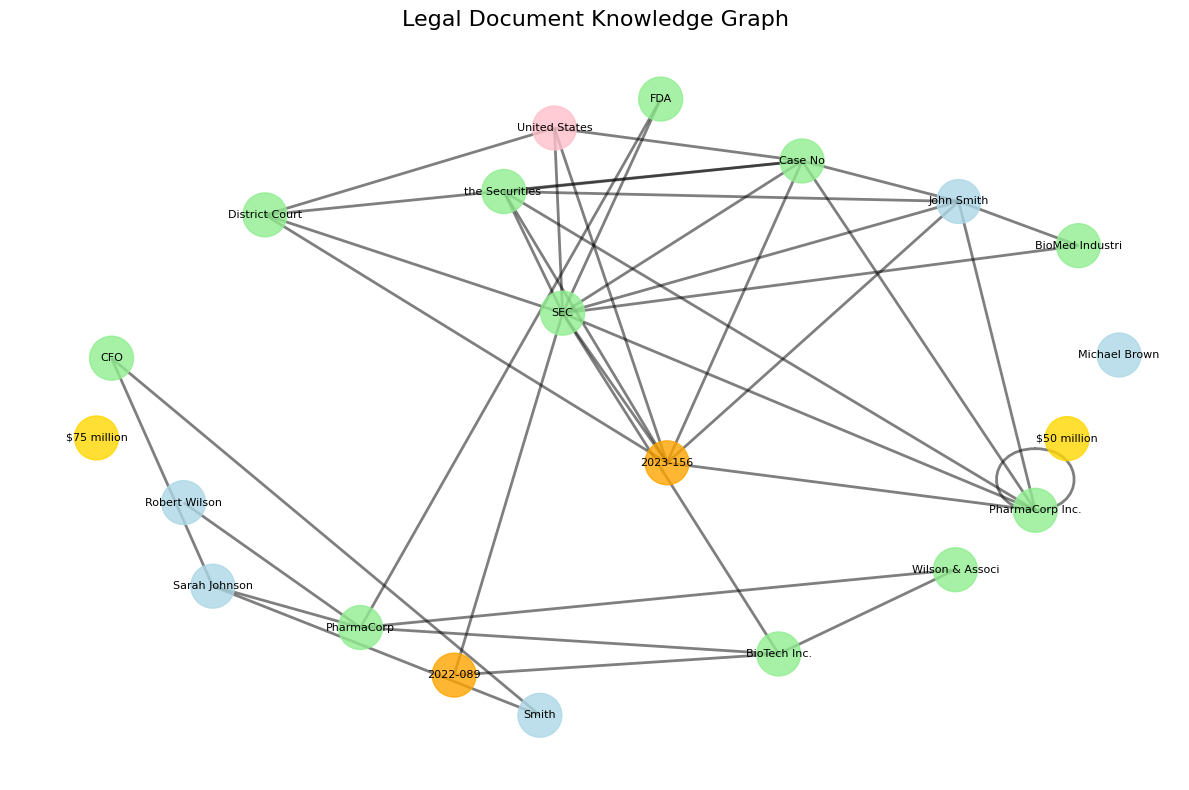

In [28]:

# =============================================================================
# STEP 4: Visualize the Graph
# =============================================================================

print("\n🎨 Visualizing Knowledge Graph...")

plt.figure(figsize=(12, 8))

# Create layout
pos = nx.spring_layout(graph, k=2, iterations=50)

# Color nodes by type
node_colors = []
color_map = {
    'PERSON': 'lightblue', 
    'ORG': 'lightgreen', 
    'CASE_NUMBER': 'orange',
    'MONEY': 'gold',
    'GPE': 'pink'
}

for node in graph.nodes():
    node_type = graph.nodes[node]['type']
    node_colors.append(color_map.get(node_type, 'gray'))

# Draw the graph
nx.draw_networkx_nodes(graph, pos, node_color=node_colors, 
                      node_size=1000, alpha=0.8)
nx.draw_networkx_edges(graph, pos, alpha=0.5, width=2)

# Add labels
labels = {node: graph.nodes[node]['name'][:15] for node in graph.nodes()}
nx.draw_networkx_labels(graph, pos, labels, font_size=8)

plt.title("Legal Document Knowledge Graph", fontsize=16)
plt.axis('off')
plt.tight_layout()
plt.show()


In [29]:

# =============================================================================
# STEP 5: Simple GraphRAG Query Function
# =============================================================================

def query_graph(query_text, max_hops=2):
    """Simple GraphRAG query"""
    print(f"\n🔍 Query: '{query_text}'")
    print("-" * 50)
    
    # Find relevant nodes (simple keyword matching)
    relevant_nodes = []
    query_words = query_text.lower().split()
    
    for node in graph.nodes():
        node_name = graph.nodes[node]['name'].lower()
        if any(word in node_name for word in query_words):
            relevant_nodes.append(node)
    
    if not relevant_nodes:
        print("❌ No relevant entities found")
        return
    
    print(f"📍 Found {len(relevant_nodes)} relevant entities:")
    for node in relevant_nodes:
        print(f"  • {graph.nodes[node]['name']} ({graph.nodes[node]['type']})")
    
    # Expand to include connected nodes
    expanded_nodes = set(relevant_nodes)
    for node in relevant_nodes:
        neighbors = list(graph.neighbors(node))
        expanded_nodes.update(neighbors[:5])  # Limit to prevent huge results
    
    # Create subgraph
    subgraph = graph.subgraph(expanded_nodes)
    
    print(f"\n🕸️ Expanded network: {len(subgraph.nodes)} entities, {len(subgraph.edges)} connections")
    
    # Analyze relationships
    print("\n🔗 Key Relationships:")
    for edge in subgraph.edges(data=True):
        source_name = subgraph.nodes[edge[0]]['name']
        target_name = subgraph.nodes[edge[1]]['name']
        rel_type = edge[2].get('relation_type', 'CONNECTED')
        print(f"  • {source_name} --[{rel_type}]--> {target_name}")
    
    # Show contexts
    print(f"\n📝 Supporting Evidence:")
    contexts_shown = 0
    for edge in subgraph.edges(data=True):
        if 'contexts' in edge[2] and contexts_shown < 3:
            print(f"  • {edge[2]['contexts'][0][:100]}...")
            contexts_shown += 1
    
    return subgraph


In [30]:

# =============================================================================
# STEP 6: Test GraphRAG Queries
# =============================================================================

print("\n" + "="*60)
print("🚀 TESTING GRAPHRAG QUERIES")
print("="*60)

# Test Query 1
subgraph1 = query_graph("PharmaCorp executives fraud")

# Test Query 2  
subgraph2 = query_graph("John Smith connections")

# Test Query 3
subgraph3 = query_graph("case numbers SEC investigations")



🚀 TESTING GRAPHRAG QUERIES

🔍 Query: 'PharmaCorp executives fraud'
--------------------------------------------------
📍 Found 2 relevant entities:
  • PharmaCorp Inc. (ORG)
  • PharmaCorp (ORG)

🕸️ Expanded network: 11 entities, 19 connections

🔗 Key Relationships:
  • SEC --[EXECUTIVE_OF]--> PharmaCorp Inc.
  • SEC --[EXECUTIVE_OF]--> Case No
  • SEC --[EXECUTIVE_OF]--> the Securities and Exchange Commission
  • SEC --[EXECUTIVE_OF]--> John Smith
  • SEC --[MENTIONED_WITH]--> BioTech Inc.
  • SEC --[MENTIONED_WITH]--> FDA
  • PharmaCorp Inc. --[EXECUTIVE_OF]--> Case No
  • PharmaCorp Inc. --[EXECUTIVE_OF]--> the Securities and Exchange Commission
  • PharmaCorp Inc. --[EXECUTIVE_OF]--> PharmaCorp Inc.
  • PharmaCorp Inc. --[EXECUTIVE_OF]--> John Smith
  • Case No --[EXECUTIVE_OF]--> the Securities and Exchange Commission
  • Case No --[EXECUTIVE_OF]--> John Smith
  • the Securities and Exchange Commission --[EXECUTIVE_OF]--> John Smith
  • Sarah Johnson --[EMPLOYMENT]--> PharmaCorp
 

In [42]:

# =============================================================================
# STEP 7: Compare with Traditional RAG
# =============================================================================

print("\n" + "="*60)
print("🆚 TRADITIONAL RAG vs GRAPHRAG COMPARISON")
print("="*60)

def traditional_rag_simulation(query):
    """Simulate what traditional RAG would return"""
    print(f"\n📰 Traditional RAG for: '{query}'")
    print("Would return these isolated chunks:")
    
    # Simple keyword search in documents
    query_words = query.lower().split()
    chunks = []
    
    for doc_id, text in documents.items():
        sentences = text.split('.')
        for sentence in sentences:
            if any(word in sentence.lower() for word in query_words):
                chunks.append(sentence.strip()[:100] + "...")
    
    for i, chunk in enumerate(chunks[:3], 1):
        print(f"  {i}. {chunk}")
    
    print("❌ Issues: Isolated facts, no relationships, missing context")

# Compare both approaches
test_query = "PharmaCorp executives"

traditional_rag_simulation(test_query)
query_graph(test_query)

print(f"\n✅ GraphRAG Benefits:")
print("  • Shows entity relationships and connections")
print("  • Reveals patterns across multiple documents") 
print("  • Provides network context and supporting evidence")
print("  • Enables multi-hop reasoning")



🆚 TRADITIONAL RAG vs GRAPHRAG COMPARISON

📰 Traditional RAG for: 'PharmaCorp executives'
Would return these isolated chunks:
  1. PharmaCorp Inc...
  2. 2023-156, the Securities and Exchange Commission 
    filed charges against PharmaCorp Inc...
  3. PharmaCorp had previously faced FDA warnings...
❌ Issues: Isolated facts, no relationships, missing context

🔍 Query: 'PharmaCorp executives'
--------------------------------------------------
❌ No relevant entities found

✅ GraphRAG Benefits:
  • Shows entity relationships and connections
  • Reveals patterns across multiple documents
  • Provides network context and supporting evidence
  • Enables multi-hop reasoning


In [43]:

# =============================================================================
# STEP 8: Graph Statistics
# =============================================================================

print("\n📊 GRAPH STATISTICS")
print("-" * 30)
print(f"Total entities: {len(graph.nodes)}")
print(f"Total relationships: {len(graph.edges)}")
print(f"Graph density: {nx.density(graph):.3f}")
print(f"Connected components: {nx.number_connected_components(graph)}")

# Most connected entities
degree_centrality = nx.degree_centrality(graph)
top_central = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:5]

print(f"\nMost connected entities:")
for node, centrality in top_central:
    name = graph.nodes[node]['name']
    node_type = graph.nodes[node]['type']
    print(f"  • {name} ({node_type}): {centrality:.3f}")

print(f"\n🎯 Try your own queries by calling: query_graph('your question here')")


📊 GRAPH STATISTICS
------------------------------
Total entities: 0
Total relationships: 0
Graph density: 0.000
Connected components: 0

Most connected entities:

🎯 Try your own queries by calling: query_graph('your question here')


In [ ]:
                ┌────────────────────┐
                │   User Query       │
                └────────┬───────────┘
                         │
                         ▼
                ┌────────────────────┐
                │   Embed Query      │ ◄─ Using dense embedding model (e.g., SBERT, OpenAI)
                └────────┬───────────┘
                         │
                         ▼
                ┌────────────────────┐
                │ Vector Search (kNN)│ ◄─ In vector store (e.g., FAISS, Pinecone)
                └────────┬───────────┘
                         │
                         ▼
                ┌────────────────────┐
                │ Retrieve Top-k Docs│
                └────────┬───────────┘
                         │
                         ▼
                ┌────────────────────┐
                │  Format Context    │
                └────────┬───────────┘
                         │
                         ▼
                ┌────────────────────┐
                │  Prompt LLM (RAG)  │ ◄─ Append query + context
                └────────┬───────────┘
                         │
                         ▼
                ┌────────────────────┐
                │   Generated Answer │
                └────────────────────┘
